In [107]:
import random
from datetime import datetime
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from scipy.stats import norm
from scipy import stats

from sklearn.metrics import mean_squared_error as MSE, r2_score as R2

from IPython.display import Image

In [108]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [109]:
DATASET_PATH = './real-estate-price-prediction-moscow/train.csv'
PREPARED_DATASET_PATH = './real-estate-price-prediction-moscow/prepared_data.csv'

REPORTS_FILE_PATH = './reports/'
SCALER_FILE_PATH = './models/scaler.pkl'
MODEL_FILE_PATH = './models/model.pkl'

In [110]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df



In [111]:
df = pd.read_csv(DATASET_PATH, sep=',')
df = reduce_mem_usage(df)
df.head()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750


Описание датасета

id - идентификационный номер квартиры<br/>
DistrictId - идентификационный номер района<br/>
Rooms - количество комнат<br/>
Square - площадь<br/>
LifeSquare - жилая площадь<br/>
KitchenSquare - площадь кухни<br/>
Floor - этаж<br/>
HouseFloor - количество этажей в доме<br/>
HouseYear - год постройки дома<br/>
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности<br/>
Social_1, Social_2, Social_3 - социальные показатели местности<br/>
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья<br/>
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров<br/>
Price - цена квартиры (Целевая переменная)<br/>

Первичные гипотезы по уменьшению количества признаков:</br>
(выводы с первого осмотра Датафрейма)</br>

1) DistrictID - маркировочная велична не имеющая, количественной и географической значимости, вероятно нужно выбросить признак
(Предварительно нужно еще раз посмотреть на него)

2)Square, lifesquare, kitchensquare - скорее всего сильно коррелируют и нужно объединить их во что-то одно

3)
Ecology_1, Ecology_2, Ecology_3</br>
Social_1, Social_2, Social_3</br>
Healthcare_1, Helthcare_2</br>
Shops_1, Shops_2</br>

Каждую группу однородных признаков скорее всего надо будет привести к одному признаку для каждой групп
#### Осмотр данных (EDA)

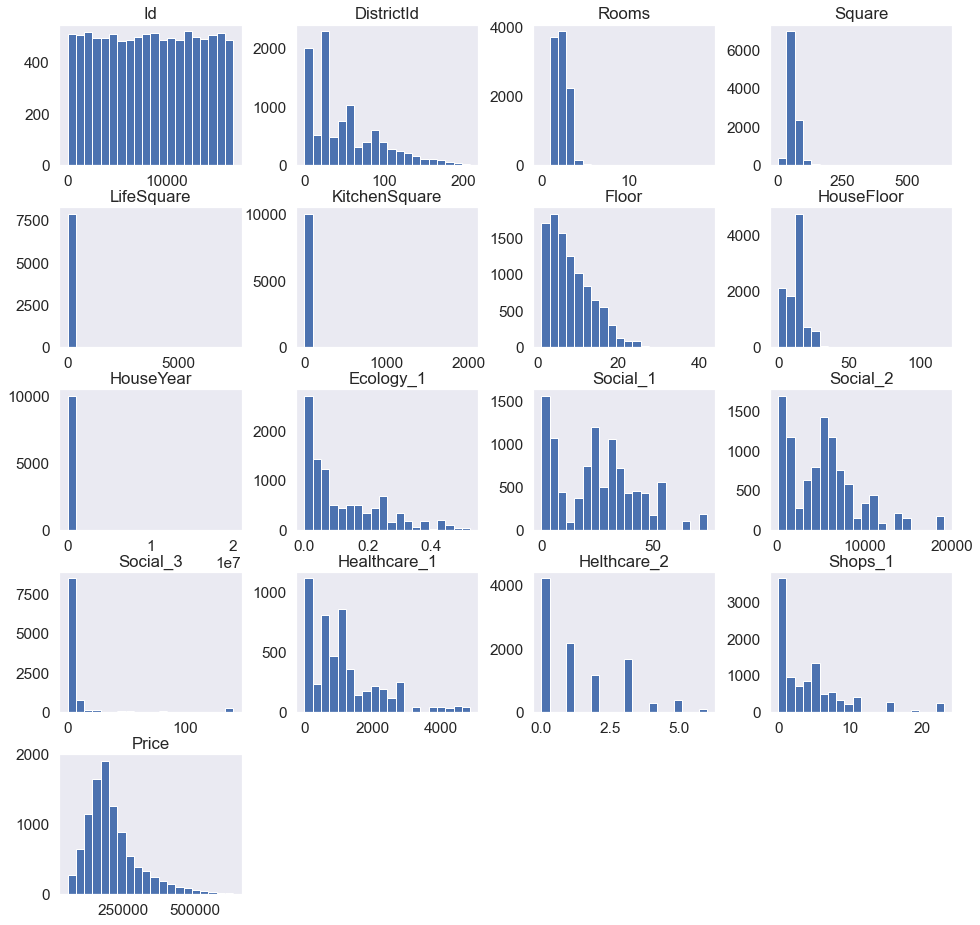

In [112]:
df.hist(figsize=(16,16), bins=20, grid=False);

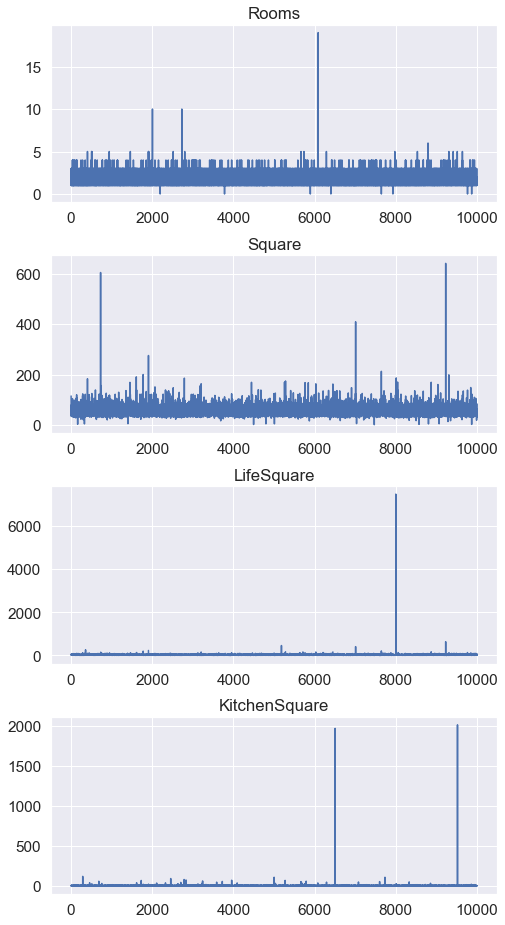

In [113]:
# Строим графики по комнатам и площадям от часла объектов чтобы посмотреть на количественные данные
def set_plots(df):
    fig, ax = plt.subplots(nrows=4, ncols=1)
    ax1, ax2, ax3, ax4 = ax.flatten()

    ax1.plot(df['Rooms'])
    ax2.plot(df['Square'])
    ax3.plot(df['LifeSquare'])
    ax4.plot(df['KitchenSquare'])
    ax1.set_title('Rooms')
    ax2.set_title('Square')
    ax3.set_title('LifeSquare')
    ax4.set_title('KitchenSquare')


    fig.set_size_inches(8, 16)
    plt.subplots_adjust(hspace=0.3)

set_plots(df)

# Посмотрев на данные понятно что все что больше 6ти комнат - выбросы.
# Абсолютно неадыкватные данные 3 объекта таких

In [114]:
# Возьмем уменьшенный дата фрейм по площадам и комнатам
df_rooms_sample = pd.DataFrame(df, columns=['Rooms', 'Square','LifeSquare','KitchenSquare', 'Price'])
df_rooms_sample.nlargest(10, 'Rooms')

,Rooms,Square,LifeSquare,KitchenSquare,Price
6088,19.0,42.006046,21.779287,7.0,78364.617188
2004,10.0,59.056976,36.223072,10.0,317265.312500
2728,10.0,60.871265,38.420681,10.0,172329.265625
8794,6.0,59.414333,38.702244,6.0,229661.968750
403,5.0,183.382278,100.985504,15.0,622888.812500
505,5.0,112.135521,79.795448,10.0,471833.781250
511,5.0,124.933289,81.122368,30.0,271919.875000
940,5.0,117.855972,76.561317,9.0,608674.125000
1459,5.0,121.577423,114.913841,1.0,455446.406250
1906,5.0,275.645294,233.949310,26.0,455264.875000


Строим таблицы самых больших значений

In [115]:
df_rooms_sample.nlargest(10, 'Square')

,Rooms,Square,LifeSquare,KitchenSquare,Price
9229,2.0,641.065186,638.163208,10.0,133529.687500
726,2.0,604.705994,NaN,1.0,187717.250000
7010,1.0,409.425171,410.639740,10.0,90470.429688
1906,5.0,275.645294,233.949310,26.0,455264.875000
7644,0.0,212.932358,211.231125,0.0,302211.250000
1776,4.0,200.334534,201.627365,25.0,528560.500000
9307,5.0,198.930176,123.139862,10.0,345665.218750
1606,3.0,190.857681,107.376167,19.0,338644.062500
8011,4.0,186.692596,87.487083,32.0,423443.468750
2790,4.0,185.906403,84.830078,31.0,340273.250000


In [116]:
df_rooms_sample.nlargest(10, 'LifeSquare')

,Rooms,Square,LifeSquare,KitchenSquare,Price
8000,3.0,81.694420,7480.592285,1.0,217357.500000
9229,2.0,641.065186,638.163208,10.0,133529.687500
5183,3.0,78.059334,461.463623,10.0,394253.312500
7010,1.0,409.425171,410.639740,10.0,90470.429688
357,2.0,48.449875,263.542023,5.0,141780.234375
1906,5.0,275.645294,233.949310,26.0,455264.875000
7644,0.0,212.932358,211.231125,0.0,302211.250000
1776,4.0,200.334534,201.627365,25.0,528560.500000
5283,1.0,174.649521,174.837082,15.0,232766.187500
8872,3.0,169.509933,170.713654,1.0,200800.671875


In [117]:
df_rooms_sample.nlargest(40, 'KitchenSquare')
# Пока будем считать что все что больше 125 - выбросы.
# Мне этот признак вообще не нравится, слишком большая площадь кухни по отношению к общей


,Rooms,Square,LifeSquare,KitchenSquare,Price
9520,1.0,47.100719,46.447960,2014.0,108337.484375
6505,1.0,32.276665,19.278395,1970.0,105539.554688
286,3.0,123.430069,125.806984,123.0,234194.843750
5002,3.0,114.734474,112.589081,112.0,315245.531250
7733,3.0,116.405693,113.109650,112.0,296165.937500
2454,3.0,97.490677,99.323555,96.0,445074.968750
2785,1.0,38.220257,18.716856,84.0,99079.960938
2831,2.0,79.810532,79.578964,78.0,438708.718750
3956,3.0,78.445679,47.146755,75.0,290354.468750
5273,1.0,38.071693,19.723547,73.0,160488.031250


In [118]:
# создаем целевой Series для графиков зависимостей
target = pd.Series(df['Price'])
target

0       305018.875000
1       177734.546875
2       282078.718750
3       168106.000000
4       343995.093750
            ...      
9995    119367.453125
9996    199715.156250
9997    165953.906250
9998    171842.406250
9999    177685.625000
Name: Price, Length: 10000, dtype: float32

Строим зависимости различных признаков от целевой переменной чтобы посмотреть поведение

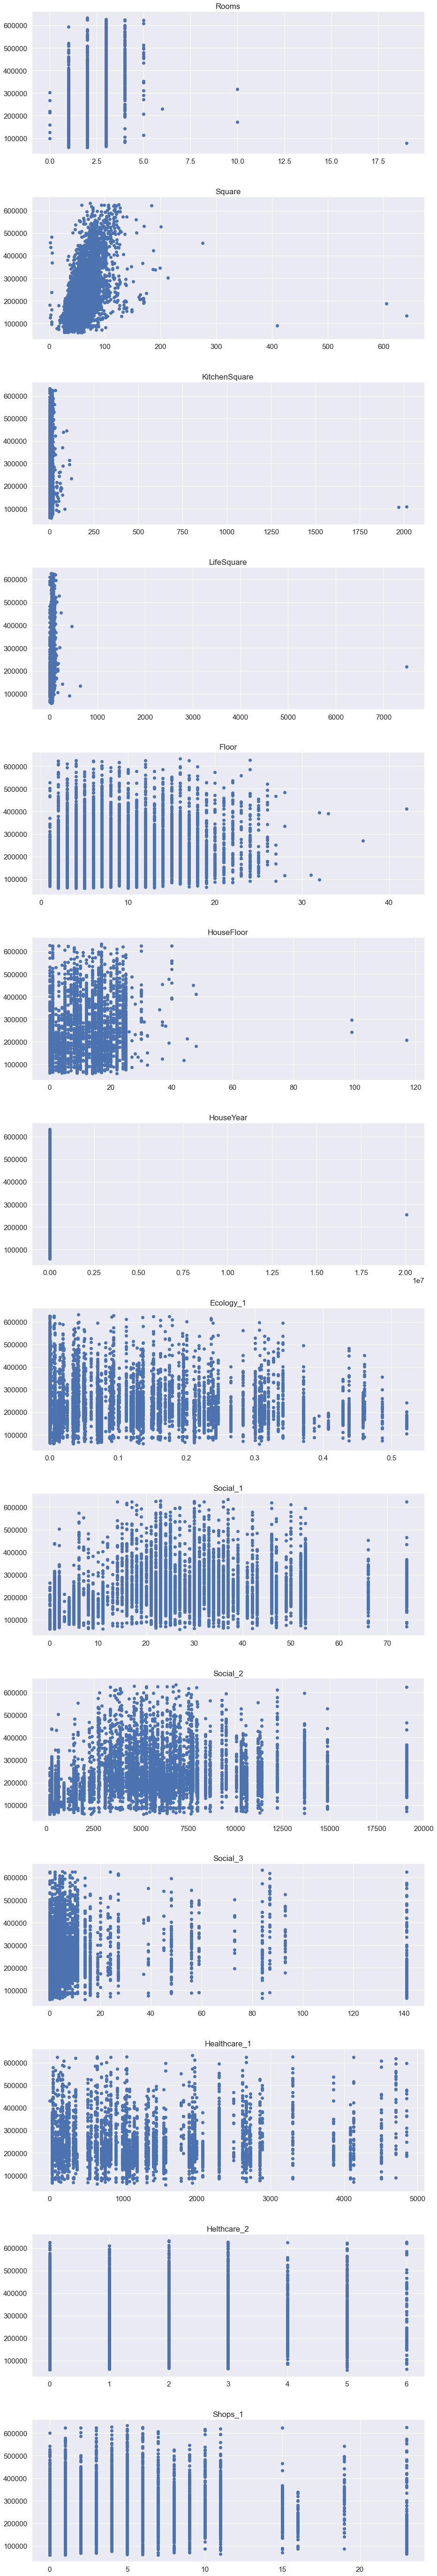

In [119]:
# Понимаю что это некрасивый хардкод, но на цикл уйдет больше времени
# На данном этапе оставлю так
def scatter_target_dependencies(df, target_series):
    fig, ax = plt.subplots(nrows=14, ncols=1)
    ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14 = ax.flatten()

    ax1.scatter(df['Rooms'], target_series)
    ax2.scatter(df['Square'], target_series)
    ax3.scatter(df['KitchenSquare'], target_series)
    ax4.scatter(df['LifeSquare'], target_series)
    ax5.scatter(df['Floor'], target_series)
    ax6.scatter(df['HouseFloor'], target_series)
    ax7.scatter(df['HouseYear'], target_series)
    ax8.scatter(df['Ecology_1'], target_series)
    ax9.scatter(df['Social_1'], target_series)
    ax10.scatter(df['Social_2'], target_series)
    ax11.scatter(df['Social_3'], target_series)
    ax12.scatter(df['Healthcare_1'], target_series)
    ax13.scatter(df['Helthcare_2'], target_series)
    ax14.scatter(df['Shops_1'], target_series)

    ax1.set_title('Rooms')
    ax2.set_title('Square')
    ax3.set_title('KitchenSquare')
    ax4.set_title('LifeSquare')
    ax5.set_title('Floor')
    ax6.set_title('HouseFloor')
    ax7.set_title('HouseYear')
    ax8.set_title('Ecology_1')
    ax9.set_title('Social_1')
    ax10.set_title('Social_2')
    ax11.set_title('Social_3')
    ax12.set_title('Healthcare_1')
    ax13.set_title('Helthcare_2')
    ax14.set_title('Shops_1')



    fig.set_size_inches(15, 100)
    plt.subplots_adjust(hspace=0.3)

scatter_target_dependencies(df, target)

# Этажность дома выше 90 явно выбросы, остальные признаки сопоставимы по отношению к признаку этажа


In [120]:
houseYear = pd.Series(df['HouseYear'])
houseYear.nlargest(5)
#Дома больше 2020 года выбросные

9163    20052011
8828        4968
1004        2020
1077        2020
1976        2020
Name: HouseYear, dtype: int32

In [121]:
df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

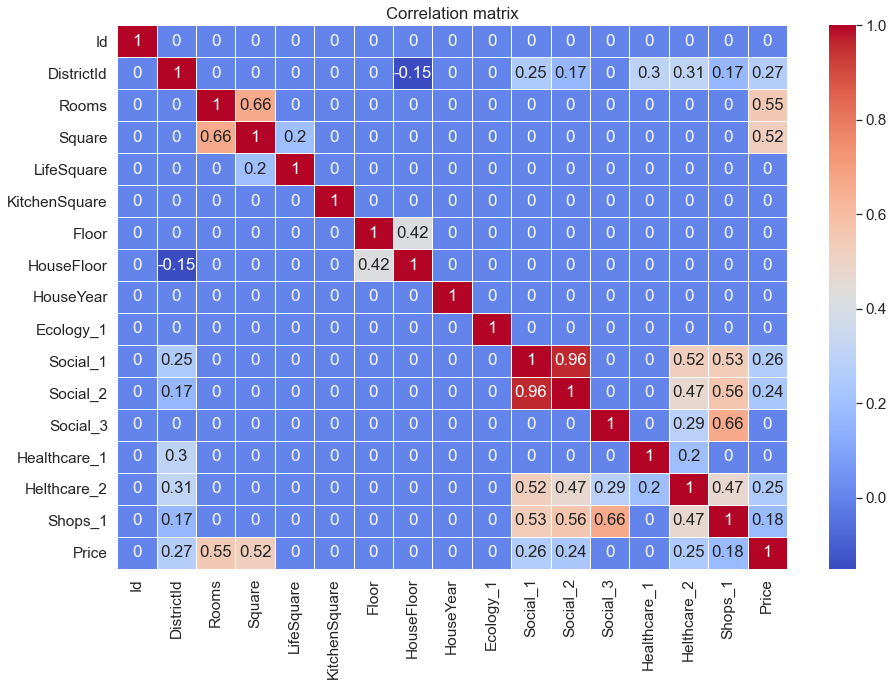

In [123]:
# Строим матрицу корреляций
def corr_matrix(df):
    plt.figure(figsize = (15,10))

    sns.set(font_scale=1.4)

    corr_matrix = df.corr()
    corr_matrix = np.round(corr_matrix, 2)
    corr_matrix[np.abs(corr_matrix) < 0.15] = 0

    sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

    plt.title('Correlation matrix')
    plt.show()

corr_matrix(df)

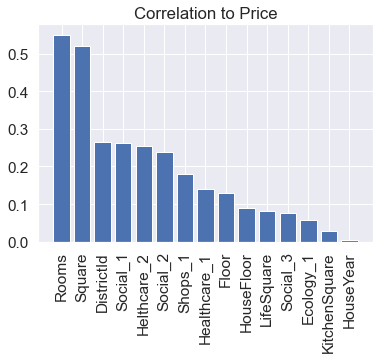

In [124]:
corrmat = df.loc[:, df.columns != 'Id'].corrwith(
    df['Price']).abs().sort_values(ascending=False)[1:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to Price')
plt.xticks(rotation='vertical')
plt.show()

In [125]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Выводы:</br>
1) Выбросы удаляем из данных<br/>
2) Признак комнат >= 6 - выбросы<br/>
3) Sqare > 277 - выбросы<br/>
4) LifeSqare > 640 - выбросы<br/>
5) KitchenSquare > 125 - выбросы<br/>
6) HouseFloor > 90 - выбросы<br/>
7) HouseYear > 2020 - выбросы<br/>
8) LifeSqare, Healthcare_1 - имеют много пропусков надо обработать<br/>
9) LifeSqare обработаю следующим образом: От площади отниму 10, услвная величина проходит по всем данным<br/>
10) Healtcare_1 - скорее всего надо заполнить средними значениями признака.<br/>
11) Есть три категориальных переменных Ecology_2, Ecology_3, Shops_2<br/>
12) Матрица корреляции говорит о том что Social_1, Social_2 очень сильно коррелируют - их надо объединять в один<br/>

Поработаем с категориальными признаками

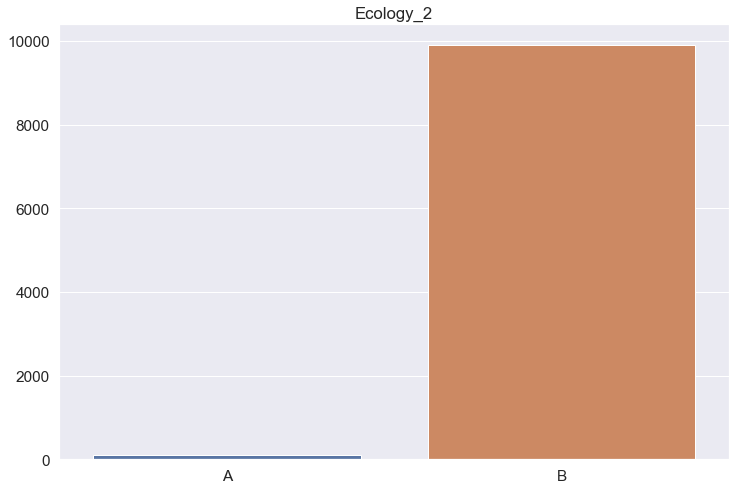

In [126]:
# Функция построения гистограммы бинарных признаков
def counts_bar(data_frame, feature_name):
    counts = data_frame[feature_name].value_counts()
    plt.figure(figsize=(12,8))
    plt.title(feature_name)
    sns.barplot(counts.index, counts.values)
    plt.show()

counts_bar(df, 'Ecology_2')

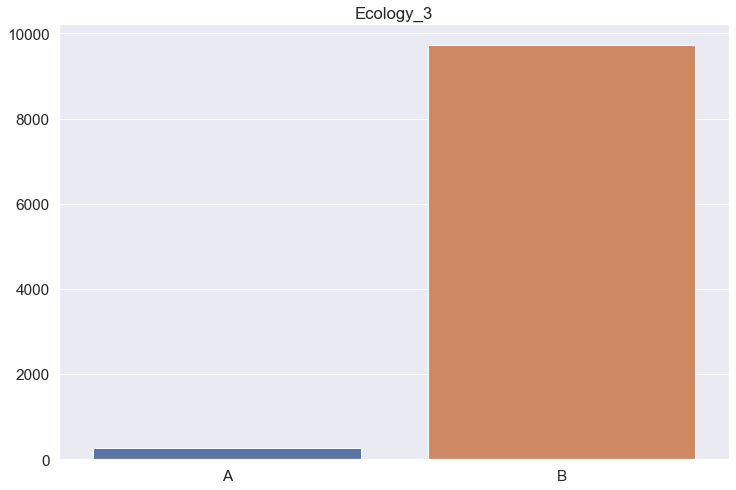

In [127]:
counts_bar(df, 'Ecology_3')

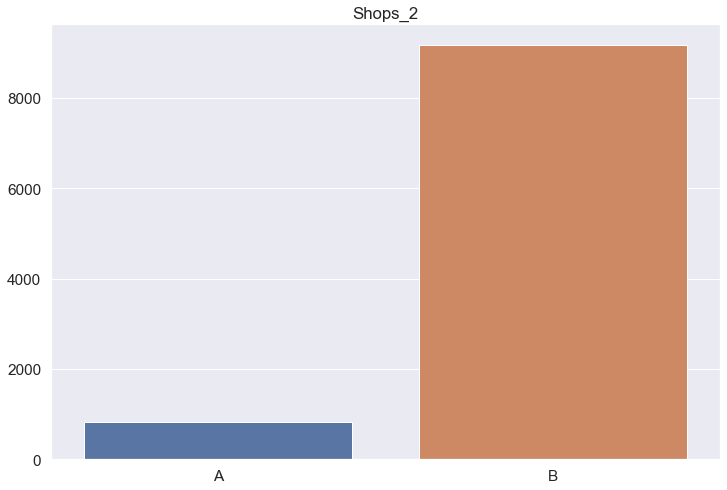

In [128]:
counts_bar(df, 'Shops_2')

In [129]:
df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [130]:
# Преобразование категорий в соответствующие числа
def cat_to_numeric(data_frame):
    for col in data_frame.columns:
        if not pd.api.types.is_numeric_dtype(data_frame[col].dtype):
            data_frame.replace({col: {'A': 1, 'B': 0}}, inplace=True)

cat_to_numeric(df)

In [131]:
df.dtypes

Id                 int16
DistrictId         int16
Rooms            float32
Square           float32
LifeSquare       float32
KitchenSquare    float32
Floor               int8
HouseFloor       float32
HouseYear          int32
Ecology_1        float32
Ecology_2          int64
Ecology_3          int64
Social_1            int8
Social_2           int16
Social_3           int16
Healthcare_1     float32
Helthcare_2         int8
Shops_1             int8
Shops_2            int64
Price            float32
dtype: object

In [132]:
df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,0,0,11,3097,0,NaN,0,0,0,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,0,0,30,6207,1,1183.0,1,0,0,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,0,0,33,5261,0,240.0,3,1,0,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,0,0,1,264,0,NaN,0,1,0,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,0,0,33,8667,2,NaN,0,6,0,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,0,0,52,10311,6,NaN,1,9,0,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,0,0,2,629,1,NaN,0,0,1,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,0,0,20,4386,14,NaN,1,5,0,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,0,0,47,8004,3,125.0,3,5,0,171842.406250


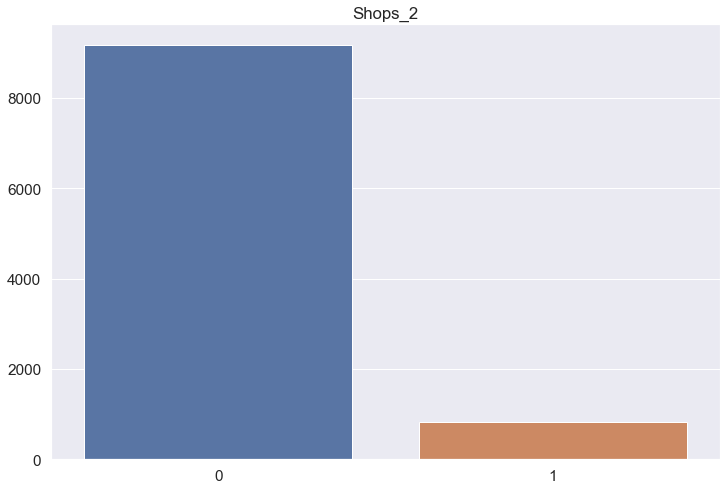

In [133]:
counts_bar(df, 'Shops_2')



In [134]:
#Функция обработки id-шников
def clean_id(df):
    #Удаляем id из данных
    df.drop('Id', axis=1, inplace=True)

In [135]:
# Обрабатываем id датафрейма и проверяем
clean_id(df)
df.dtypes

DistrictId         int16
Rooms            float32
Square           float32
LifeSquare       float32
KitchenSquare    float32
Floor               int8
HouseFloor       float32
HouseYear          int32
Ecology_1        float32
Ecology_2          int64
Ecology_3          int64
Social_1            int8
Social_2           int16
Social_3           int16
Healthcare_1     float32
Helthcare_2         int8
Shops_1             int8
Shops_2            int64
Price            float32
dtype: object

Нужно обработать пропуски

In [136]:
#Функция для обработки пропусков жилой площади
def fill_na(df):
    # Добавляю новые признаки-метки для признаков с пропусками
    df.loc[df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
    df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
    # Определяю среднюю разницу между общей площадью и жилой площадью, эту величину я буду отнимать где пропуски
    # от общей площади дома для заполнения пропусков
    df_without_nan_life_square = df[~df['LifeSquare'].isna()]
    df_without_nan_life_square['Square - LifeSquare'] = df_without_nan_life_square['Square'] - df_without_nan_life_square['LifeSquare']
    diff_square = df_without_nan_life_square['Square - LifeSquare'].mean()
    df['LifeSquare'].fillna(df['Square'] - diff_square, inplace=True)
    # Добавляю обработку пропусков Healthcare средними значениями
    health_mean = df['Healthcare_1'].mean()
    df['Healthcare_1'].fillna(health_mean, inplace=True)
    df['LifeSquare_nan'].fillna(0, inplace=True)
    df['Healthcare_1_nan'].fillna(0, inplace=True)
    df.fillna(df.median(), inplace=True)
#Применяю функции заполняю все пропуски вывожу DataFrame
fill_na(df)
df

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Healthcare_1_nan
0,27,3.0,115.027313,96.992699,10.0,4,10.0,2014,0.075424,0,...,11,3097,0,1142.904419,0,0,0,305018.875000,1.0,1.0
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,0,...,30,6207,1,1183.000000,1,0,0,177734.546875,0.0,0.0
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,0,...,33,5261,0,240.000000,3,1,0,282078.718750,0.0,0.0
3,1,1.0,40.409908,22.375292,1.0,10,22.0,1977,0.007122,0,...,1,264,0,1142.904419,0,1,0,168106.000000,1.0,1.0
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,0,...,33,8667,2,1142.904419,0,6,0,343995.093750,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,0,...,52,10311,6,1142.904419,1,9,0,119367.453125,0.0,1.0
9996,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,0,...,2,629,1,1142.904419,0,0,1,199715.156250,0.0,1.0
9997,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,0,...,20,4386,14,1142.904419,1,5,0,165953.906250,0.0,1.0
9998,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,0,...,47,8004,3,125.000000,3,5,0,171842.406250,0.0,0.0


In [137]:
#Проверяю пропуски (в конечном варианте функции она убирает пропуски и создает признаки)
df.isna().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1        0
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
LifeSquare_nan      0
Healthcare_1_nan    0
dtype: int64

Разбираемся с пропусками для Healthcare_1

In [138]:
df['Healthcare_1'].mode()


0    1142.904419
dtype: float32

In [139]:
df['Healthcare_1'].mean()


1142.9044

In [140]:
df['Healthcare_1'].median()


1142.9044

In [141]:
df.nlargest(40, columns=('Healthcare_1'))


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Healthcare_1_nan
777,155,1.0,32.651943,23.927309,5.0,3,9.0,1967,0.042307,0,...,17,2810,9,4849.0,3,6,0,185878.375000,0.0,0.0
1761,155,2.0,61.714108,32.486988,9.0,7,6.0,1931,0.042307,0,...,17,2810,9,4849.0,3,6,0,362698.812500,0.0,0.0
2213,155,1.0,35.391014,21.122438,5.0,4,5.0,1966,0.042307,0,...,17,2810,9,4849.0,3,6,0,190016.984375,0.0,0.0
2844,105,3.0,71.093712,46.573040,7.0,6,5.0,1931,0.042307,0,...,17,2810,9,4849.0,3,6,0,387442.875000,0.0,0.0
2852,133,3.0,81.654022,56.918652,9.0,7,11.0,1959,0.042307,0,...,17,2810,9,4849.0,3,6,0,474671.843750,0.0,0.0
4234,155,3.0,78.520752,45.130306,9.0,16,16.0,1989,0.042307,0,...,17,2810,9,4849.0,3,6,0,598541.375000,0.0,0.0
5028,133,3.0,83.197182,54.767353,8.0,8,8.0,1961,0.042307,0,...,17,2810,9,4849.0,3,6,0,479612.531250,0.0,0.0
5236,105,1.0,41.066383,19.878588,8.0,7,16.0,1981,0.042307,0,...,17,2810,9,4849.0,3,6,0,199636.937500,0.0,0.0
5838,133,2.0,48.599586,28.653719,6.0,5,9.0,1967,0.042307,0,...,17,2810,9,4849.0,3,6,0,247894.562500,0.0,0.0
6455,155,2.0,46.474941,27.587831,5.0,3,5.0,1967,0.042307,0,...,17,2810,9,4849.0,3,6,0,280267.875000,0.0,0.0


По самым большим значениям Healthcare_1 и по графикам выше, вижу что "выбросных" данных нет<br/>
Пропуски можно заолнять средними значениями, далее я отредактирую функцию выше в ноутбуке,<br/>

Функция сможет заполнять наши пропуски.



In [142]:
#Добавляем признак средней цены по району города
med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                        .rename(columns={'Price':'MedPriceByDistrict'})

def district_transform_feature(df):
    #Добавляем признак размера района города
    distr_info = df['DistrictId'].value_counts().reset_index().\
                rename(columns={"index": "DistrictId", "DistrictId": 'District_size'})
    df = pd.merge(df, distr_info, on='DistrictId', how='left')
    df['District_size'] = df['District_size'].fillna(1)

    #Присоединяем признак города к новому датафрейму
    df = df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
    #Удаляем признак DistrictId, он больше не нужен
    df.drop('DistrictId', axis=1, inplace=True)
    return df
df = district_transform_feature(df)

In [143]:
df.dtypes

Rooms                 float32
Square                float32
LifeSquare            float32
KitchenSquare         float32
Floor                    int8
HouseFloor            float32
HouseYear               int32
Ecology_1             float32
Ecology_2               int64
Ecology_3               int64
Social_1                 int8
Social_2                int16
Social_3                int16
Healthcare_1          float32
Helthcare_2              int8
Shops_1                  int8
Shops_2                 int64
Price                 float32
LifeSquare_nan        float64
Healthcare_1_nan      float64
District_size           int64
MedPriceByDistrict    float32
dtype: object

Произвели генерацию признаков размера районов и средней стоимости квартир по районам.
Избавились от DistrictId сам по себе признак бесполезен, способствует генерацию других признаков

Далее надо работать с выбросами.

In [144]:
def house_floor_outliers(df):
    df['HouseFloor_outlier'] = 0
    df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
    df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_outlier'] = 1

    df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df.median()['HouseFloor']

    floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
    df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor']\
                                        .apply(lambda x: random.randint(1, x))

def house_year_outliers(df):
    current_year = datetime.now().year

    df['HouseYear_outlier'] = 0
    df.loc[df['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
    df.loc[df['HouseYear'] > current_year, 'HouseYear'] = current_year

def drop_outliers_train(df):
    outliers = pd.concat([df[df['Rooms'] >= 6], df[df['Square'] > 277], df[df['LifeSquare'] > 640], df[df['KitchenSquare'] > 125]], axis=0)

    df.drop(outliers.index, axis=0, inplace=True)

house_year_outliers(df)
house_floor_outliers(df)
drop_outliers_train(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9990 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rooms               9990 non-null   float32
 1   Square              9990 non-null   float32
 2   LifeSquare          9990 non-null   float32
 3   KitchenSquare       9990 non-null   float32
 4   Floor               9990 non-null   int64  
 5   HouseFloor          9990 non-null   float32
 6   HouseYear           9990 non-null   int32  
 7   Ecology_1           9990 non-null   float32
 8   Ecology_2           9990 non-null   int64  
 9   Ecology_3           9990 non-null   int64  
 10  Social_1            9990 non-null   int8   
 11  Social_2            9990 non-null   int16  
 12  Social_3            9990 non-null   int16  
 13  Healthcare_1        9990 non-null   float32
 14  Helthcare_2         9990 non-null   int8   
 15  Shops_1             9990 non-null   int8   
 16  Shops_

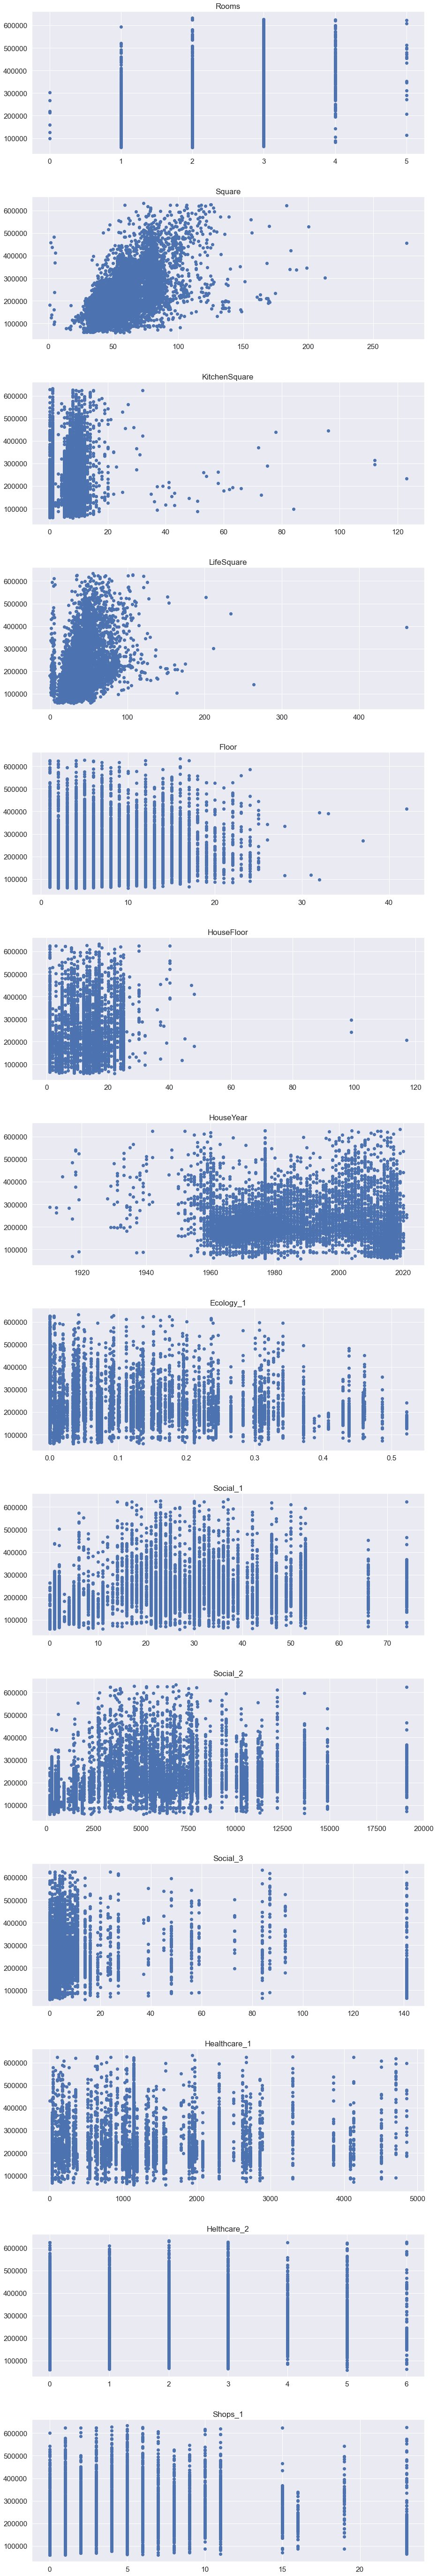

In [145]:
target = pd.Series(df['Price'])
scatter_target_dependencies(df, target)


От сильно выбросных данных избавились, пропуски заполнены<br/>
Общая картина более-менее адекватная<br/>
Пока не понятна зависимость года, поэтому нужно сделать кластеризацию по годам<br/>

Далее надо сжимать Social 2 и Social1 и сделать кластеризацию для HouseYear
Для дальнейших операций надо сделать стандартизацию и создать стандартизированные данные

In [146]:
#Сохраняем предобработанные данные в файл
df.to_csv(PREPARED_DATASET_PATH, sep=',')

In [147]:
#Обучаем MinMaxScaler
scaler = MinMaxScaler()
#Делаем разбиение на test и train и заключаем в функцию т.к потом будем еще раз бить данные
#и обучать скалер
def split_and_x_scale(df):
    x = df.drop('Price', axis=1)
    y = df['Price']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=100)
    colnames = x.columns
    x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=colnames)
    #Применяем MinMaxScaler
    x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=colnames)
    return x_train, x_test, y_train, y_test, x_train_scaled, x_test_scaled
x_train, x_test, y_train, y_test, x_train_scaled, x_test_scaled = split_and_x_scale(df)
x_train_scaled.head(2)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan,District_size,MedPriceByDistrict,HouseYear_outlier,HouseFloor_outlier
0,0.4,0.182001,0.109707,0.081301,0.4375,0.137931,0.811321,0.213900,0.0,0.0,...,0.402573,0.333333,0.130435,0.0,0.0,0.0,0.071765,0.279709,0.0,0.0
1,0.4,0.201999,0.125931,0.065041,0.1250,0.094828,0.641509,0.601541,0.0,0.0,...,0.793733,0.333333,0.434783,0.0,0.0,0.0,0.032941,0.259761,0.0,0.0


In [148]:
# Обучаем PCA
social_train= x_train_scaled[['Social_1', 'Social_2']]
pca = PCA(n_components=1, random_state=100)
social_train['Social_1+2'] = pca.fit_transform(social_train)
# Подготавливаю данные для применения PCA
social_scaled_transform = pd.concat([x_train_scaled[['Social_1', 'Social_2']], x_test_scaled[['Social_1', 'Social_2']]], axis=0)
social_scaled_transform

,Social_1,Social_2
0,0.675676,0.638118
1,0.297297,0.235633
2,0.716216,0.713825
3,0.337838,0.289717
4,0.459459,0.401322
...,...,...
2493,0.297297,0.329368
2494,0.081081,0.067090
2495,0.027027,0.024372
2496,0.716216,0.713825


In [149]:
#Делаю функцию для преобразования фич
def transform_social_features(main_df, scaled_social_df):

    social_scaled = pca.transform(scaled_social_df)
    main_df['Social_1+2_scaled'] = social_scaled
    main_df.drop(['Social_1', 'Social_2'], axis=1, inplace=True)

transform_social_features(df, social_scaled_transform)

In [150]:
df


,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_1,Shops_2,Price,LifeSquare_nan,Healthcare_1_nan,District_size,MedPriceByDistrict,HouseYear_outlier,HouseFloor_outlier,Social_1+2_scaled
0,3.0,115.027313,96.992699,10.0,4,10.0,2014,0.075424,0,0,...,0,0,305018.875000,1.0,1.0,851,213530.781250,0,0,0.500346
1,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,0,0,...,0,0,177734.546875,0.0,0.0,78,146032.828125,0,0,-0.049848
2,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,0,0,...,1,0,282078.718750,0.0,0.0,652,244005.281250,0,0,0.580941
3,1.0,40.409908,22.375292,1.0,10,22.0,1977,0.007122,0,0,...,1,0,168106.000000,1.0,1.0,652,146735.671875,0,0,0.016382
4,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,0,0,...,6,0,343995.093750,0.0,1.0,89,201584.437500,0,0,0.181429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,0,0,...,9,0,119367.453125,0.0,1.0,118,232514.843750,0,0,0.012418
9996,2.0,64.307686,37.038422,9.0,13,13.0,1977,0.072158,0,0,...,0,1,199715.156250,0.0,1.0,851,165683.078125,0,1,-0.323426
9997,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,0,0,...,5,0,165953.906250,0.0,1.0,7,165953.906250,0,0,-0.392207
9998,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,0,0,...,5,0,171842.406250,0.0,0.0,165,153921.406250,0,0,0.580941


In [151]:
# Потеря 2,3% данных при сжатии признаков
pca.explained_variance_ratio_

array([0.97851201])

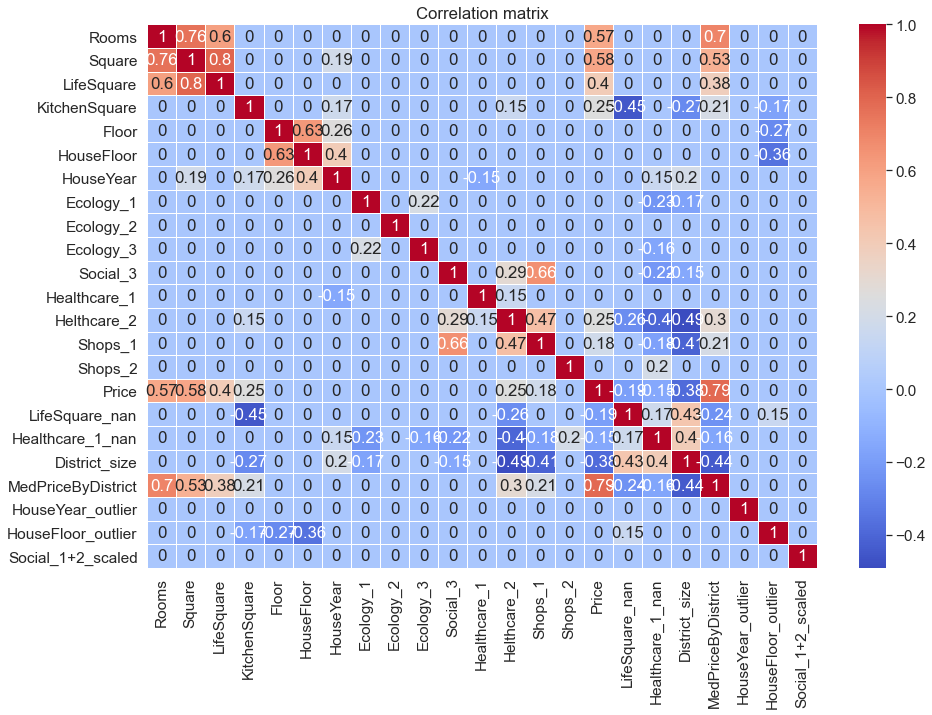

In [152]:
#Строим матрицу корреляций еще раз и проверяем корреляций больше 0.9 нет
corr_matrix(df)


Преобразовали признаки, осталось разобраться с годом дома

In [153]:
# готовим данные для кластеризации, обучаем скалер для наших кластеров

train = pd.concat([x_train, y_train], axis=1)
cluster_scaler = MinMaxScaler()
transform_social_features(train, social_train[['Social_1', 'Social_2']])
reduce_mem_usage(train)
train_cluster_scaled = pd.DataFrame(cluster_scaler.fit_transform(
    train.loc[:, ['HouseYear', 'Price']]), columns=['HouseYear', 'Price'])
train_cluster_scaled

Memory usage of dataframe is 0.94 MB
Memory usage after optimization is: 0.50 MB
Decreased by 47.0%


,HouseYear,Price
0,0.811321,0.445757
1,0.641510,0.400617
2,0.971697,0.460045
3,0.754717,0.132782
4,0.575472,0.327545
...,...,...
7487,0.594339,0.066753
7488,0.547169,0.225862
7489,0.952829,0.098930
7490,0.594339,0.535625


Text(0.5, 1.0, 'Inertia')

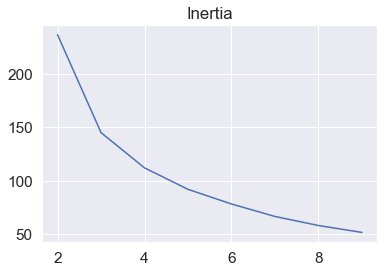

In [154]:
# Подбираем число кластеров на которые необходимо бить
# Начнем с метода ближайших соседей, ищем Inertia
inertias = []

for i in range(2, 10):
    k_means_temp = KMeans(n_clusters=i, random_state=100)
    k_means_temp.fit(train_cluster_scaled)
    temp_inertia = k_means_temp.inertia_
    inertias.append(temp_inertia)

plt.plot(range(2, 10), inertias)
plt.title('Inertia')


Из Графика выше понятно, что нам нужно 4 или 5 кластеров

In [155]:
# Делаем модельку для 4х кластеров
k_means = KMeans(n_clusters=4, random_state=100)
train_labels = k_means.fit_predict(train_cluster_scaled)

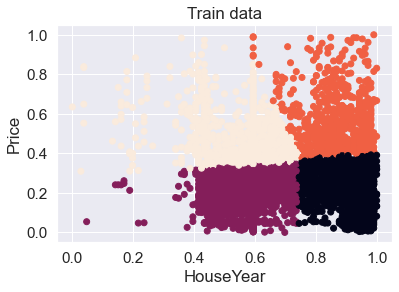

In [156]:
def cluster_scatter(cluster_scaled_df, labels):
    plt.scatter(cluster_scaled_df['HouseYear'],
            cluster_scaled_df['Price'], c=labels)
    plt.xlabel('HouseYear')
    plt.ylabel('Price')

    plt.title('Train data')

cluster_scatter(train_cluster_scaled, train_labels)

In [157]:
#k_means = KMeans(n_clusters=5, random_state=100)
#train_labels = k_means.fit_predict(train_cluster_scaled)

In [158]:
# Тут строим уже для 5ти кластеров
#cluster_scatter(train_cluster_scaled, train_labels)


Используем 5 кластеров. Посмотрим другие модели


In [159]:
agglomerative_clustering = AgglomerativeClustering(n_clusters=4)


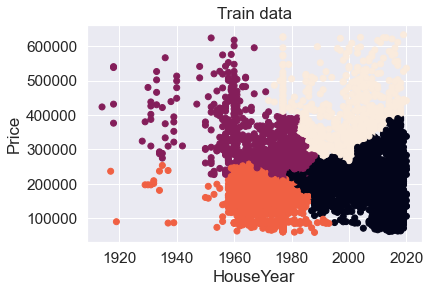

In [160]:
train['cluster_year'] = agglomerative_clustering.fit_predict(
    train_cluster_scaled)

cluster_scatter(train, train['cluster_year'])

In [161]:
#dbscan = DBSCAN(eps=0.2, min_samples=5)
#labels_claster = dbscan.fit_predict(train_cluster_scaled)
#cluster_scatter(train_cluster_scaled, labels_claster)


Очень много раз пытался посмотреть DBScan, но он не отрабатывает и считает все одним кластером<br/>
может я конечно не так что-то делаю

Посмотрел аггломеративные кластеры и Kmeans<br/>
Решил использовать K_means 4 кластера

In [162]:
# Трансформируем данные обученным скалером для кластеров
#test = pd.concat([x_test, y_test], axis=1)
transform_social_features(x_test, x_test_scaled[['Social_1', 'Social_2']])
reduce_mem_usage(x_test)
cluster_scaler.fit_transform(x_train.loc[:, ['HouseYear']])

test_cluster_scaled = pd.DataFrame(cluster_scaler.transform(
    x_test.loc[:, ['HouseYear']]), columns=['HouseYear'])
x_train['Cluster_year'] = k_means.fit_predict(train_cluster_scaled.loc[:, ['HouseYear']].astype('double'))


def add_cluster_year(df):
    df_scaled = pd.DataFrame(cluster_scaler.transform(
        df.loc[:, ['HouseYear']]), columns=['HouseYear'])
    df['Сluster_year'] = k_means.predict(df_scaled)

add_cluster_year(df)

Memory usage of dataframe is 0.30 MB
Memory usage after optimization is: 0.16 MB
Decreased by 48.4%


In [163]:
#еще раз преобразуем данные и разбиваем на тест и трейн, т.к у нас теперь конечный вариант df
#со всеми нужными признаками
x_train, x_test, y_train, y_test, x_train_scaled, x_test_scaled = split_and_x_scale(df)

In [164]:
#Собираем функцию для всех тестовых датафреймов
def data_prepare(df):
    cat_to_numeric(df)
    clean_id(df)
    fill_na(df)
    df = district_transform_feature(df)
    house_year_outliers(df)
    house_floor_outliers(df)
    test_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns)
    social_scaled = test_scaled[['Social_1', 'Social_2']]
    transform_social_features(df, social_scaled)
    add_cluster_year(df)
    df.fillna(df.median(), inplace=True)
    reduce_mem_usage(df)
    return df

In [165]:
df2 = pd.read_csv(DATASET_PATH, sep=',')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [166]:
#Загружаю датафрейм на тест, проверяю общую функцию
#На этом этапе также много дебажу
df2.drop('Price', axis=1, inplace=True)
df2 = data_prepare(df2)
df2.info()

Memory usage of dataframe is 2.01 MB
Memory usage after optimization is: 0.89 MB
Decreased by 55.6%
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rooms               10000 non-null  float32
 1   Square              10000 non-null  float32
 2   LifeSquare          10000 non-null  float32
 3   KitchenSquare       10000 non-null  float32
 4   Floor               10000 non-null  int8   
 5   HouseFloor          10000 non-null  float32
 6   HouseYear           10000 non-null  int16  
 7   Ecology_1           10000 non-null  float32
 8   Ecology_2           10000 non-null  int8   
 9   Ecology_3           10000 non-null  int8   
 10  Social_3            10000 non-null  int16  
 11  Healthcare_1        10000 non-null  float32
 12  Helthcare_2         10000 non-null  int8   
 13  Shops_1             10000 non-null  int8   
 14  Sho

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9990 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rooms               9990 non-null   float32
 1   Square              9990 non-null   float32
 2   LifeSquare          9990 non-null   float32
 3   KitchenSquare       9990 non-null   float32
 4   Floor               9990 non-null   int64  
 5   HouseFloor          9990 non-null   float32
 6   HouseYear           9990 non-null   int32  
 7   Ecology_1           9990 non-null   float32
 8   Ecology_2           9990 non-null   int64  
 9   Ecology_3           9990 non-null   int64  
 10  Social_3            9990 non-null   int16  
 11  Healthcare_1        9990 non-null   float32
 12  Helthcare_2         9990 non-null   int8   
 13  Shops_1             9990 non-null   int8   
 14  Shops_2             9990 non-null   int64  
 15  Price               9990 non-null   float32
 16  LifeSq

Данные подготовлены, теперь обучаем модели и подбираем лучшую



In [168]:
# Делаем функции для тестов моделей

def model_test(model, name, test, valid):
    model_pred = model.predict(test)
    r2 = R2(valid, model_pred)
    mse = MSE(valid, model_pred)
    plt.scatter(valid, (model_pred - valid))
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.title(name)
    plt.legend([f'R2= {r2:.4f} and mse= {mse:.0e}'])
    plt.axhline(0, color='red')
    plt.show()

In [169]:
# Делаем функцию для построения отклонений
def model_top_deviation(model, test, valid):
    model_pred = model.predict(test)
    model_test = test.copy()
    model_test['Price'] = model_pred
    model_test['Price_test'] = valid
    model_test['SD'] = abs(model_test['Price']
                           - model_test['Price_test'])
    return model_test.nlargest(10, 'SD')



In [170]:
models_dict = {}

###### Linear Regression

In [171]:
line_regression = LinearRegression().fit(x_train_scaled, y_train)
models_dict['Linear Regression'] = line_regression

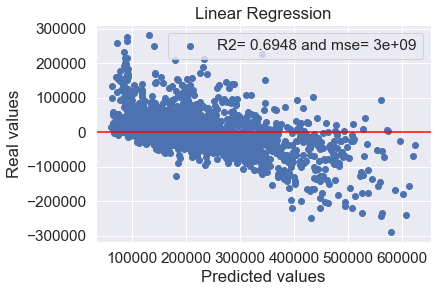

In [172]:
model_test(line_regression, 'Linear Regression', x_test_scaled, y_test)


In [173]:
model_top_deviation(line_regression, x_test_scaled, y_test)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Healthcare_1_nan,District_size,MedPriceByDistrict,HouseYear_outlier,HouseFloor_outlier,Social_1+2_scaled,Сluster_year,Price,Price_test,SD
1026,0.2,0.168656,0.116324,0.000000,0.25000,0.206897,0.594340,0.466028,0.0,0.0,...,0.0,0.600000,0.082289,0.0,0.0,0.362808,0.000000,141141.136797,624156.000000,483014.863203
51,0.4,0.190659,0.139118,0.008130,0.28125,0.094828,0.594340,0.066408,0.0,0.0,...,1.0,0.663529,0.105798,0.0,0.0,0.363974,0.000000,134242.325593,555661.937500,421419.611907
599,0.4,0.214972,0.123372,0.008130,0.28125,0.077586,0.971698,0.033815,0.0,0.0,...,1.0,1.000000,0.149569,0.0,0.0,0.106737,0.333333,163512.168097,571939.937500,408427.769403
2453,0.6,0.381355,0.336668,0.000000,0.18750,0.103448,0.594340,0.037383,0.0,0.0,...,0.0,0.077647,0.727548,0.0,1.0,0.074498,0.000000,478872.494373,75170.812500,403701.681873
2447,0.6,0.363874,0.223339,0.121951,0.15625,0.137931,0.981132,0.037383,0.0,0.0,...,0.0,0.077647,0.727548,0.0,0.0,0.070502,0.333333,485984.523336,105418.007812,380566.515524
2393,0.2,0.193809,0.097965,0.081301,0.50000,0.137931,0.877358,0.303236,0.0,0.0,...,1.0,0.041176,0.156172,0.0,0.0,0.414839,0.333333,218592.399181,573451.625000,354859.225819
780,0.6,0.309663,0.262400,0.121951,0.71875,0.206897,0.943396,0.078803,0.0,0.0,...,1.0,0.104706,0.642567,0.0,0.0,0.009543,0.333333,430628.704522,85164.828125,345463.876397
2276,0.2,0.143544,0.082874,0.073171,0.00000,0.112069,0.584906,0.097535,0.0,0.0,...,0.0,0.095294,0.116742,0.0,0.0,0.102465,0.000000,153852.230323,494516.343750,340664.113427
61,0.8,0.306011,0.223937,0.073171,0.18750,0.068966,0.462264,0.612818,0.0,0.0,...,0.0,0.020000,0.780907,0.0,0.0,0.531212,0.666667,463433.716641,124902.554688,338531.161954
10,0.2,0.122364,0.070579,0.073171,0.15625,0.112069,0.830189,0.078787,0.0,0.0,...,1.0,0.082353,0.160488,0.0,0.0,0.366652,1.000000,176870.000518,512797.375000,335927.374482


###### Random Forest

In [174]:
random_forest_regressor = RandomForestRegressor().fit(x_train_scaled, y_train)
models_dict['Random Forest Regressor'] = random_forest_regressor

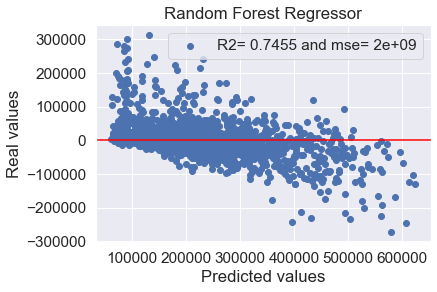

In [175]:
model_test(random_forest_regressor,
           'Random Forest Regressor', x_test_scaled, y_test)

In [176]:
model_top_deviation(random_forest_regressor, x_test_scaled, y_test)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Healthcare_1_nan,District_size,MedPriceByDistrict,HouseYear_outlier,HouseFloor_outlier,Social_1+2_scaled,Сluster_year,Price,Price_test,SD
1026,0.2,0.168656,0.116324,0.000000,0.25000,0.206897,0.594340,0.466028,0.0,0.0,...,0.0,0.600000,0.082289,0.0,0.0,0.362808,0.000000,147548.232734,624156.000000,476607.767266
51,0.4,0.190659,0.139118,0.008130,0.28125,0.094828,0.594340,0.066408,0.0,0.0,...,1.0,0.663529,0.105798,0.0,0.0,0.363974,0.000000,111168.947188,555661.937500,444492.990312
2453,0.6,0.381355,0.336668,0.000000,0.18750,0.103448,0.594340,0.037383,0.0,0.0,...,0.0,0.077647,0.727548,0.0,1.0,0.074498,0.000000,514523.848750,75170.812500,439353.036250
2447,0.6,0.363874,0.223339,0.121951,0.15625,0.137931,0.981132,0.037383,0.0,0.0,...,0.0,0.077647,0.727548,0.0,0.0,0.070502,0.333333,515648.462969,105418.007812,410230.455156
599,0.4,0.214972,0.123372,0.008130,0.28125,0.077586,0.971698,0.033815,0.0,0.0,...,1.0,1.000000,0.149569,0.0,0.0,0.106737,0.333333,167786.622891,571939.937500,404153.314609
2393,0.2,0.193809,0.097965,0.081301,0.50000,0.137931,0.877358,0.303236,0.0,0.0,...,1.0,0.041176,0.156172,0.0,0.0,0.414839,0.333333,185538.239922,573451.625000,387913.385078
61,0.8,0.306011,0.223937,0.073171,0.18750,0.068966,0.462264,0.612818,0.0,0.0,...,0.0,0.020000,0.780907,0.0,0.0,0.531212,0.666667,490587.262813,124902.554688,365684.708125
10,0.2,0.122364,0.070579,0.073171,0.15625,0.112069,0.830189,0.078787,0.0,0.0,...,1.0,0.082353,0.160488,0.0,0.0,0.366652,1.000000,167413.066094,512797.375000,345384.308906
2276,0.2,0.143544,0.082874,0.073171,0.00000,0.112069,0.584906,0.097535,0.0,0.0,...,0.0,0.095294,0.116742,0.0,0.0,0.102465,0.000000,150892.427578,494516.343750,343623.916172
730,0.4,0.232218,0.182171,0.000000,0.12500,0.103448,0.594340,0.466028,0.0,0.0,...,0.0,0.600000,0.174148,0.0,1.0,0.070502,0.000000,175218.860313,502523.562500,327304.702187


###### Gradient Boosting Regressor

In [177]:
gradient_boosting_regressor = GradientBoostingRegressor().fit(x_train_scaled, y_train)
models_dict['Gradient Boosting Regressor'] = gradient_boosting_regressor

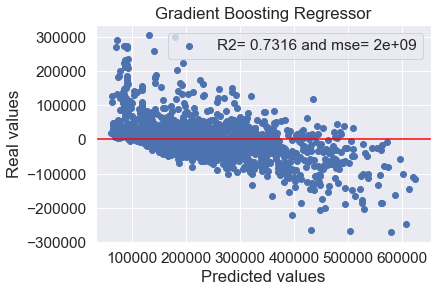

In [178]:
model_test(gradient_boosting_regressor,
           'Gradient Boosting Regressor', x_test_scaled, y_test)

In [179]:
model_top_deviation(gradient_boosting_regressor, x_test_scaled, y_test)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Healthcare_1_nan,District_size,MedPriceByDistrict,HouseYear_outlier,HouseFloor_outlier,Social_1+2_scaled,Сluster_year,Price,Price_test,SD
1026,0.2,0.168656,0.116324,0.000000,0.25000,0.206897,0.594340,0.466028,0.0,0.0,...,0.0,0.600000,0.082289,0.0,0.0,0.362808,0.000000,136783.641255,624156.000000,487372.358745
51,0.4,0.190659,0.139118,0.008130,0.28125,0.094828,0.594340,0.066408,0.0,0.0,...,1.0,0.663529,0.105798,0.0,0.0,0.363974,0.000000,126859.322396,555661.937500,428802.615104
2453,0.6,0.381355,0.336668,0.000000,0.18750,0.103448,0.594340,0.037383,0.0,0.0,...,0.0,0.077647,0.727548,0.0,1.0,0.074498,0.000000,500945.378411,75170.812500,425774.565911
599,0.4,0.214972,0.123372,0.008130,0.28125,0.077586,0.971698,0.033815,0.0,0.0,...,1.0,1.000000,0.149569,0.0,0.0,0.106737,0.333333,167620.189023,571939.937500,404319.748477
2393,0.2,0.193809,0.097965,0.081301,0.50000,0.137931,0.877358,0.303236,0.0,0.0,...,1.0,0.041176,0.156172,0.0,0.0,0.414839,0.333333,191668.484744,573451.625000,381783.140256
2276,0.2,0.143544,0.082874,0.073171,0.00000,0.112069,0.584906,0.097535,0.0,0.0,...,0.0,0.095294,0.116742,0.0,0.0,0.102465,0.000000,151258.416472,494516.343750,343257.927278
61,0.8,0.306011,0.223937,0.073171,0.18750,0.068966,0.462264,0.612818,0.0,0.0,...,0.0,0.020000,0.780907,0.0,0.0,0.531212,0.666667,461155.067914,124902.554688,336252.513226
10,0.2,0.122364,0.070579,0.073171,0.15625,0.112069,0.830189,0.078787,0.0,0.0,...,1.0,0.082353,0.160488,0.0,0.0,0.366652,1.000000,184683.674160,512797.375000,328113.700840
730,0.4,0.232218,0.182171,0.000000,0.12500,0.103448,0.594340,0.466028,0.0,0.0,...,0.0,0.600000,0.174148,0.0,1.0,0.070502,0.000000,175780.380813,502523.562500,326743.181687
2447,0.6,0.363874,0.223339,0.121951,0.15625,0.137931,0.981132,0.037383,0.0,0.0,...,0.0,0.077647,0.727548,0.0,0.0,0.070502,0.333333,429854.257016,105418.007812,324436.249204


###### Lasso CV

In [180]:
lasso_cv = LassoCV().fit(x_train_scaled, y_train)
models_dict['LassoCV'] = lasso_cv

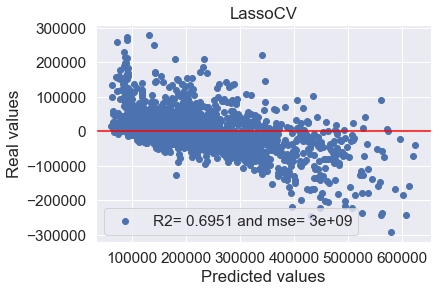

In [181]:
model_test(lasso_cv, 'LassoCV', x_test_scaled, y_test)

In [182]:
model_top_deviation(lasso_cv, x_test_scaled, y_test)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Healthcare_1_nan,District_size,MedPriceByDistrict,HouseYear_outlier,HouseFloor_outlier,Social_1+2_scaled,Сluster_year,Price,Price_test,SD
1026,0.2,0.168656,0.116324,0.000000,0.25000,0.206897,0.594340,0.466028,0.0,0.0,...,0.0,0.600000,0.082289,0.0,0.0,0.362808,0.000000,140570.129895,624156.000000,483585.870105
51,0.4,0.190659,0.139118,0.008130,0.28125,0.094828,0.594340,0.066408,0.0,0.0,...,1.0,0.663529,0.105798,0.0,0.0,0.363974,0.000000,134646.798542,555661.937500,421015.138958
599,0.4,0.214972,0.123372,0.008130,0.28125,0.077586,0.971698,0.033815,0.0,0.0,...,1.0,1.000000,0.149569,0.0,0.0,0.106737,0.333333,163808.561485,571939.937500,408131.376015
2453,0.6,0.381355,0.336668,0.000000,0.18750,0.103448,0.594340,0.037383,0.0,0.0,...,0.0,0.077647,0.727548,0.0,1.0,0.074498,0.000000,478352.463615,75170.812500,403181.651115
2447,0.6,0.363874,0.223339,0.121951,0.15625,0.137931,0.981132,0.037383,0.0,0.0,...,0.0,0.077647,0.727548,0.0,0.0,0.070502,0.333333,484557.948251,105418.007812,379139.940438
2393,0.2,0.193809,0.097965,0.081301,0.50000,0.137931,0.877358,0.303236,0.0,0.0,...,1.0,0.041176,0.156172,0.0,0.0,0.414839,0.333333,217606.294699,573451.625000,355845.330301
780,0.6,0.309663,0.262400,0.121951,0.71875,0.206897,0.943396,0.078803,0.0,0.0,...,1.0,0.104706,0.642567,0.0,0.0,0.009543,0.333333,430996.034787,85164.828125,345831.206662
2276,0.2,0.143544,0.082874,0.073171,0.00000,0.112069,0.584906,0.097535,0.0,0.0,...,0.0,0.095294,0.116742,0.0,0.0,0.102465,0.000000,153213.158844,494516.343750,341303.184906
61,0.8,0.306011,0.223937,0.073171,0.18750,0.068966,0.462264,0.612818,0.0,0.0,...,0.0,0.020000,0.780907,0.0,0.0,0.531212,0.666667,463467.402645,124902.554688,338564.847958
10,0.2,0.122364,0.070579,0.073171,0.15625,0.112069,0.830189,0.078787,0.0,0.0,...,1.0,0.082353,0.160488,0.0,0.0,0.366652,1.000000,176886.477091,512797.375000,335910.897909


###### LGBMRegressor

In [183]:
lgbm_regressor = LGBMRegressor().fit(x_train_scaled, y_train)

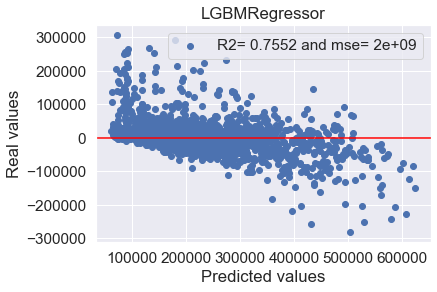

In [184]:
model_test(lgbm_regressor, 'LGBMRegressor', x_test_scaled, y_test)

In [185]:
model_top_deviation(lgbm_regressor, x_test_scaled, y_test)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Healthcare_1_nan,District_size,MedPriceByDistrict,HouseYear_outlier,HouseFloor_outlier,Social_1+2_scaled,Сluster_year,Price,Price_test,SD
2453,0.6,0.381355,0.336668,0.000000,0.18750,0.103448,0.594340,0.037383,0.0,0.0,...,0.0,0.077647,0.727548,0.0,1.0,0.074498,0.000000,573818.741693,75170.812500,498647.929193
1026,0.2,0.168656,0.116324,0.000000,0.25000,0.206897,0.594340,0.466028,0.0,0.0,...,0.0,0.600000,0.082289,0.0,0.0,0.362808,0.000000,136784.504180,624156.000000,487371.495820
51,0.4,0.190659,0.139118,0.008130,0.28125,0.094828,0.594340,0.066408,0.0,0.0,...,1.0,0.663529,0.105798,0.0,0.0,0.363974,0.000000,116334.256531,555661.937500,439327.680969
599,0.4,0.214972,0.123372,0.008130,0.28125,0.077586,0.971698,0.033815,0.0,0.0,...,1.0,1.000000,0.149569,0.0,0.0,0.106737,0.333333,166082.476555,571939.937500,405857.460945
2393,0.2,0.193809,0.097965,0.081301,0.50000,0.137931,0.877358,0.303236,0.0,0.0,...,1.0,0.041176,0.156172,0.0,0.0,0.414839,0.333333,194462.084728,573451.625000,378989.540272
2447,0.6,0.363874,0.223339,0.121951,0.15625,0.137931,0.981132,0.037383,0.0,0.0,...,0.0,0.077647,0.727548,0.0,0.0,0.070502,0.333333,474461.109975,105418.007812,369043.102163
2276,0.2,0.143544,0.082874,0.073171,0.00000,0.112069,0.584906,0.097535,0.0,0.0,...,0.0,0.095294,0.116742,0.0,0.0,0.102465,0.000000,138930.826543,494516.343750,355585.517207
61,0.8,0.306011,0.223937,0.073171,0.18750,0.068966,0.462264,0.612818,0.0,0.0,...,0.0,0.020000,0.780907,0.0,0.0,0.531212,0.666667,473732.107519,124902.554688,348829.552831
10,0.2,0.122364,0.070579,0.073171,0.15625,0.112069,0.830189,0.078787,0.0,0.0,...,1.0,0.082353,0.160488,0.0,0.0,0.366652,1.000000,171358.785171,512797.375000,341438.589829
2417,0.6,0.296753,0.209673,0.065041,0.21875,0.060345,0.443396,0.081069,0.0,0.0,...,0.0,0.004706,0.747492,0.0,0.0,0.000000,0.666667,515157.664869,186265.703125,328891.961744


Tunning LGBMRegressor

In [186]:
lgbm_regressor.get_params

<bound method LGBMModel.get_params of LGBMRegressor()>

In [187]:
np.arange(0.01, 0.05, 0.01)

array([0.01, 0.02, 0.03, 0.04])

In [188]:
parameters = [{
    'max_bin': np.arange(90, 120, 10),
    'n_estimators': np.arange(4000, 7000, 1000),
    'learning_rate': np.arange(0.01, 0.05, 0.01)
}]

In [189]:
#clf = GridSearchCV(
#    estimator=LGBMRegressor(random_state=100),
#    param_grid=parameters,
#    scoring='neg_mean_squared_error',
#    cv=4,
#    n_jobs=-1,
#).fit(x_train_scaled, y_train)


In [190]:
#cv_results = pd.DataFrame(clf.cv_results_)
#param_columns = [
#    column
#   for column in cv_results.columns
#    if column.startswith('param_')
#]

#score_columns = ['mean_test_score']

#cv_results = (cv_results[param_columns + score_columns]
#              .sort_values(by=score_columns, ascending=False))

#cv_results.head(10)



In [191]:
#clf.best_params_

Test tunning LGBMRegressor

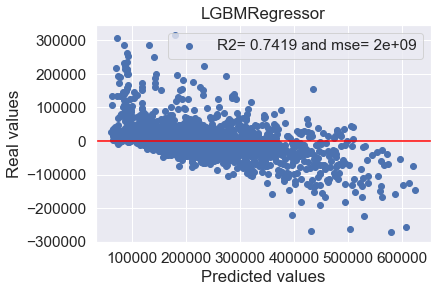

In [192]:
lgbm_regressor = LGBMRegressor(
    max_bin=110,
    num_leaves=4,
    n_estimators=4000,
    learning_rate=0.01
).fit(x_train_scaled, y_train)
model_test(lgbm_regressor, 'LGBMRegressor', x_test_scaled, y_test)

In [193]:
models_dict['LGBMRegressor'] = lgbm_regressor

###### XGBRegressor



In [194]:
xgboost = XGBRegressor().fit(x_train_scaled, y_train)
models_dict['XGBRegressor'] = xgboost

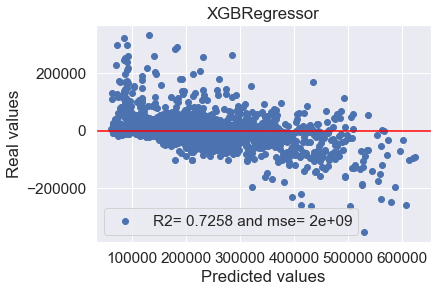

In [195]:
model_test(xgboost, 'XGBRegressor', x_test_scaled, y_test)

In [196]:
model_top_deviation(xgboost, x_test_scaled, y_test)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Healthcare_1_nan,District_size,MedPriceByDistrict,HouseYear_outlier,HouseFloor_outlier,Social_1+2_scaled,Сluster_year,Price,Price_test,SD
1026,0.2,0.168656,0.116324,0.000000,0.25000,0.206897,0.594340,0.466028,0.0,0.0,...,0.0,0.600000,0.082289,0.0,0.0,0.362808,0.000000,140481.812500,624156.000000,483674.1875
2453,0.6,0.381355,0.336668,0.000000,0.18750,0.103448,0.594340,0.037383,0.0,0.0,...,0.0,0.077647,0.727548,0.0,1.0,0.074498,0.000000,550970.812500,75170.812500,475800.0000
51,0.4,0.190659,0.139118,0.008130,0.28125,0.094828,0.594340,0.066408,0.0,0.0,...,1.0,0.663529,0.105798,0.0,0.0,0.363974,0.000000,108598.984375,555661.937500,447062.9375
2447,0.6,0.363874,0.223339,0.121951,0.15625,0.137931,0.981132,0.037383,0.0,0.0,...,0.0,0.077647,0.727548,0.0,0.0,0.070502,0.333333,525866.125000,105418.007812,420448.1250
599,0.4,0.214972,0.123372,0.008130,0.28125,0.077586,0.971698,0.033815,0.0,0.0,...,1.0,1.000000,0.149569,0.0,0.0,0.106737,0.333333,170102.046875,571939.937500,401837.8750
2393,0.2,0.193809,0.097965,0.081301,0.50000,0.137931,0.877358,0.303236,0.0,0.0,...,1.0,0.041176,0.156172,0.0,0.0,0.414839,0.333333,207361.859375,573451.625000,366089.7500
2276,0.2,0.143544,0.082874,0.073171,0.00000,0.112069,0.584906,0.097535,0.0,0.0,...,0.0,0.095294,0.116742,0.0,0.0,0.102465,0.000000,140734.218750,494516.343750,353782.1250
1650,0.4,0.363082,0.206267,0.113821,0.34375,0.094828,0.905660,0.001900,0.0,0.0,...,1.0,0.032941,0.466762,0.0,0.0,0.581397,0.333333,470547.843750,124016.851562,346531.0000
10,0.2,0.122364,0.070579,0.073171,0.15625,0.112069,0.830189,0.078787,0.0,0.0,...,1.0,0.082353,0.160488,0.0,0.0,0.366652,1.000000,167552.515625,512797.375000,345244.8750
2417,0.6,0.296753,0.209673,0.065041,0.21875,0.060345,0.443396,0.081069,0.0,0.0,...,0.0,0.004706,0.747492,0.0,0.0,0.000000,0.666667,525730.125000,186265.703125,339464.4375


In [197]:
# Объявляю функцию для построения r2 и mse
def models_r2(models, test, valid):
    scores = pd.DataFrame(columns=['name', 'r2', 'mse'])
    for name, model in models.items():
        test_pred = model.predict(test)
        r2 = R2(valid, test_pred)
        mse = MSE(valid, test_pred)
        scores = scores.append(
            {'name': name, 'r2': r2, 'mse': mse}, ignore_index=True)
    scores.sort_values('r2', ascending=False, inplace=True)
    return scores


In [198]:
models_score_test = models_r2(models_dict, x_test_scaled, y_test)
models_score_train = models_r2(models_dict, x_train_scaled, y_train)
models_score_test

,name,r2,mse
1,Random Forest Regressor,0.745517,2.241906e+09
4,LGBMRegressor,0.741902,2.273749e+09
2,Gradient Boosting Regressor,0.731600,2.364503e+09
5,XGBRegressor,0.725789,2.415695e+09
3,LassoCV,0.695087,2.686173e+09
0,Linear Regression,0.694783,2.688855e+09


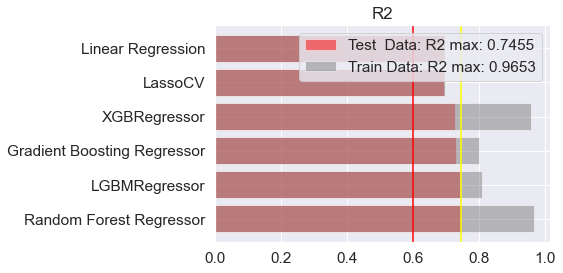

In [199]:
# Cтроим график R2
r2_max_test = models_score_test['r2'].max()
r2_max_train = models_score_train['r2'].max()
plt.barh(models_score_test['name'], models_score_test['r2'],
         alpha=0.5, color='red', label=f'Test  Data: R2 max: {r2_max_test:.4f}')
plt.barh(models_score_train['name'], models_score_train['r2'],
         alpha=0.5, color='grey', label=f'Train Data: R2 max: {r2_max_train:.4f}')
plt.title('R2')
plt.legend()
plt.axvline(0.6, color='red')
plt.axvline(r2_max_test, color='yellow')
plt.show()

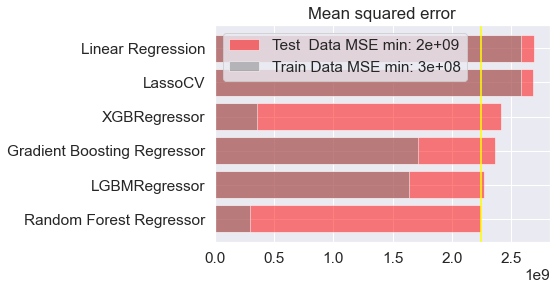

In [200]:
# Строим график MSE
mse_min_test = models_score_test['mse'].min()
mse_min_train = models_score_train['mse'].min()
plt.barh(models_score_test['name'], models_score_test['mse'],
         alpha=0.5, color='red', label=f'Test  Data MSE min: {mse_min_test:.0e}')
plt.barh(models_score_train['name'], models_score_train['mse'],
         alpha=0.5, color='grey', label=f'Train Data MSE min: {mse_min_train:.0e}')
plt.title('Mean squared error')
plt.legend(loc=2)
plt.axvline(mse_min_test, color='yellow')
plt.show()


In [201]:
best_model = models_dict['Random Forest Regressor']

In [202]:
pd.DataFrame({'name': list(x_train_scaled.columns),
              'importances': list(best_model.feature_importances_)})

,name,importances
0,Rooms,0.006829
1,Square,0.122862
2,LifeSquare,0.027295
3,KitchenSquare,0.024098
4,Floor,0.019602
5,HouseFloor,0.024420
6,HouseYear,0.025962
7,Ecology_1,0.015477
8,Ecology_2,0.000188
9,Ecology_3,0.000356


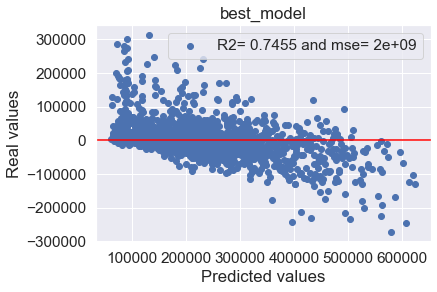

In [203]:
model_test(best_model, 'best_model', x_test_scaled, y_test)


На этом этапе я понял что MedPriceByDistrict слишком сильный признак по отношению к другим<br/>
Изначалально я обучал и тестил модель на немасштабированных данных увидел что TargetEncodingFeature очень сильный
Потом я отмасштабировал данные, но результат получается тот же самый

In [204]:
# считываем данные для теста
'./real-estate-price-prediction-moscow/prepared_data.csv'
test = pd.read_csv('./real-estate-price-prediction-moscow/test.csv', sep=',')
Id_s = test['Id']
test = data_prepare(test)
test

Memory usage of dataframe is 1.00 MB
Memory usage after optimization is: 0.45 MB
Decreased by 55.6%


,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan,District_size,MedPriceByDistrict,HouseYear_outlier,HouseFloor_outlier,Social_1+2_scaled,Сluster_year
0,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,0,0,...,1,0,0.0,0.0,46,171145.171875,0,0,0.297990,2
1,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,0,0,...,0,1,0.0,1.0,122,129107.218750,0,0,-0.335427,1
2,2.0,59.463676,40.224506,9.0,19,19.0,1977,0.211401,0,0,...,1,0,1.0,1.0,391,165683.078125,0,0,-0.124217,0
3,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,0,0,...,0,0,0.0,1.0,264,166687.734375,0,0,-0.356655,2
4,1.0,53.837055,34.597885,1.0,8,17.0,1977,0.309479,0,0,...,6,0,1.0,0.0,61,165071.828125,0,0,0.816300,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,1,5.0,1962,0.069660,0,0,...,2,0,0.0,1.0,60,185083.531250,0,1,0.575091,2
4996,3.0,93.698120,94.521461,10.0,21,27.0,2018,0.060753,0,0,...,7,0,0.0,0.0,16,425037.656250,0,0,0.030964,1
4997,1.0,33.656723,19.003260,5.0,2,5.0,1966,0.038693,0,0,...,5,0,0.0,0.0,46,151926.375000,0,0,0.616256,2
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,0,0,...,11,0,0.0,1.0,16,167742.765625,0,0,0.841676,2


In [205]:
test_features = x_train_scaled.columns

In [206]:
test_features_scaled = scaler.transform(test[test_features])

In [207]:
test['Price'] = best_model.predict(test_features_scaled)

mu = 216378.89 and sigma = 76818.29


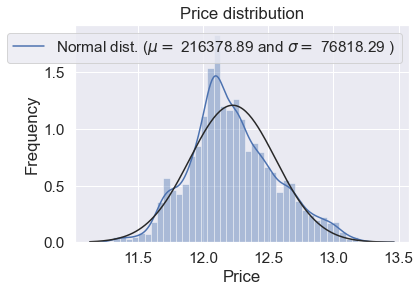

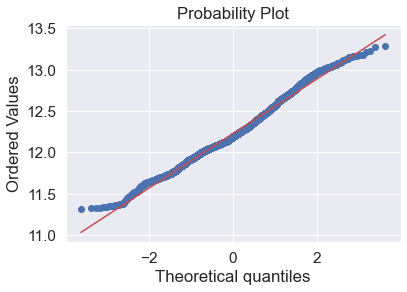

In [208]:
price_log = np.log1p(test['Price'])
sns.distplot(price_log, fit=norm)

mu, sigma = norm.fit(test['Price'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(price_log, plot=plt)
plt.show()

In [209]:
test['Id'] = Id_s
test[['Id', 'Price']].to_csv('NickHlzv_predictions.csv', index=None)
